# River outlets
*** 

***Author:** Chus Casado Rodríguez*<br>
***Date:** 29-01-2025*<br>

**Introduction**<br>
This notebook selects the river outlets into the oceans that will be later on used to extract to extract discharge time series from the GloFAS historical run.

**Output**<br>

* A shapefile of river outlets including the ocean to which they flow to.
* A CSV file of the same river outlets that is needed to run the [`ncextract`](https://github.com/ec-jrc/lisflood-utilities/wiki/ncextract) tool, that used to extract the discharge time series from the GloFAS historical run.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import rioxarray as rxr
from pathlib import Path
from scipy.ndimage import generic_filter
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

## Configuration

In [4]:
# paths
PATH_IN = Path('../data/GloFAS')
PATH_SOTCIN = Path('E:/casadje/Documents/BAMS_SoCin2024/')
PATH_OUT = PATH_IN / 'discharge'

# thresholds
MIN_AREA = 5e3 # km2
SINK = 5 # value in the LDD map that represents a sink

## Data

In [5]:
# load upstream area map
uparea = rxr.open_rasterio(PATH_IN / 'static_maps' / 'upArea.nc').squeeze(dim='band')
uparea = uparea.where(uparea >= 0, np.nan)
uparea /= 1e6 # km2

# load local drainage direction map
ldd = rxr.open_rasterio(PATH_IN / 'static_maps' / 'ldd.nc').squeeze(dim='band')
ldd = ldd.where(ldd <= 16, np.nan)

In [6]:
# basins = gpd.read_file('Z:/H07_Global/GloFAS/2023GISdata/FAOacquastat2023/MAJ_BAS.shp')

## Processing

In [12]:
# mask of upstream area 10,000 km2
mask_area = uparea >= MIN_AREA
# mask of sinks
mask_ldd = ldd == SINK

# filter pixels
outlets = uparea.where(
    mask_area & mask_ldd,
    np.nan
)

# convert to pandas and keep only outlets
outlets = outlets.to_dataframe().reset_index()
outlets = outlets[outlets.Band1.notnull()]
print('No. outlets:\t{0}'.format(len(outlets)))

# convert to geopandas points
points = [Point(x, y) for x, y in zip(outlets.x, outlets.y)]
outlets = gpd.GeoDataFrame(outlets, geometry=points, crs='epsg:4326')

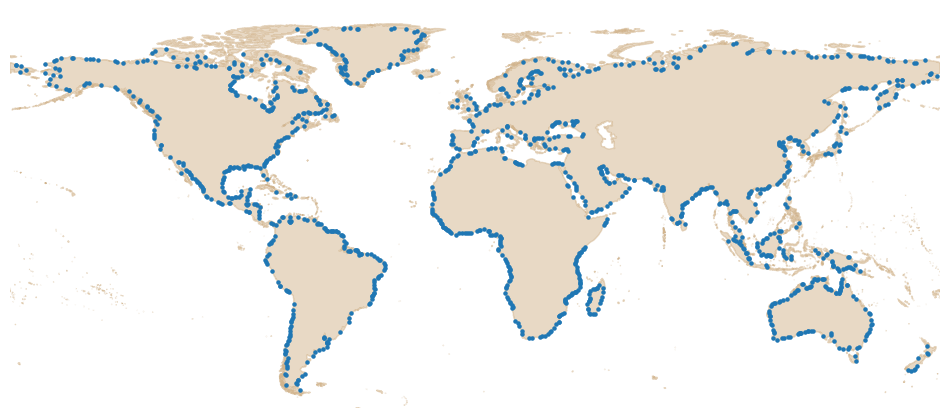

In [70]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
# basins.boundary.plot(ax=ax, edgecolor='w', linewidth=0.25, zorder=1);
# ax.scatter(
#     outlets.geometry.x,
#     outlets.geometry.y,
#     s=5
# )
outlets.plot(markersize=5, ax=ax);
ax.axis('off');

In [22]:
# export
output_file = PATH_OUT / f'outlets_{MIN_AREA:.0f}km2.shp'
outlets.to_file(output_file)
print(f'Point shapefile of river outlets saved in:\t{output_file}')

Point shapefile of river outlets saved in:	E:\casadje\Documents\BAMS_SoCin2024\GIS\outlets_5000km2.shp


I have processed the shapefile in QGIS to remove manually points inland (endorheic basins) and to create a field named _ocean_ that classifies the points in Atlantic, Pacific, Indian or Arctic Ocean. The modified layer was saved as the shapefile _outlets_5000km2_ocean.shp_.

In [38]:
# load modified river outlets
outlets = gpd.read_file(PATH_OUT / f'outlets_{MIN_AREA:.0f}km2_ocean.shp')

# rename columns and index
outlets.rename(columns={'y': 'latitude', 'x': 'longitude', 'Band1': 'area'}, inplace=True)
outlets.index.name = 'ID'

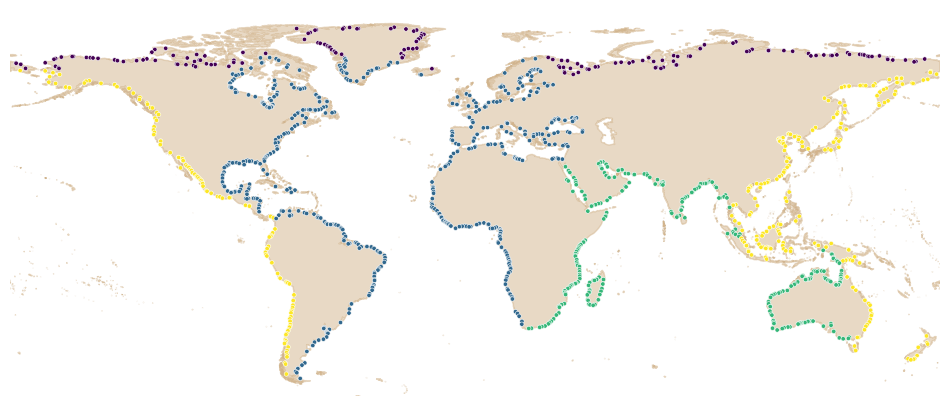

In [69]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
# basins.boundary.plot(ax=ax, edgecolor='w', linewidth=0.25, zorder=1);
ax.scatter(
    outlets.geometry.x,
    outlets.geometry.y,
    s=10,
    c=pd.Categorical(outlets.ocean).codes,
    edgecolor='w',
    lw=.4,
    cmap='viridis'
    
)
ax.axis('off');

plt.savefig('river_outlets.png', dpi=300, bbox_inches='tight');

## Export results

In [58]:
# export CSV file needed as input in `ncextract`
csv_file = PATH_OUT / f'outlets_{MIN_AREA:.0f}km2_ocean.csv'
outlets[['latitude', 'longitude']].to_csv(csv_file, float_format='%.3f')
print(f'CSV file of river outlets saved in:\t{csv_file}')

CSV file of river outlets saved in:	E:\casadje\Documents\BAMS_SoCin2024\GIS\outlets_5000km2_ocean.csv


In [ ]:
# export a shapefile
shp_file = PATH_OUT / f'outlets_{MIN_AREA:.0f}km2_ocean.csv'
outlets[['latitude', 'longitude']].to_csv(shp_file, float_format='%.3f')
print(f'Shapefile of river outlets saved in:\t{shp_file}')